# Strategy
#### Timeseries required (example)
1. Generate initial Hurst exp (H_0) using one month worth of 1hr data (672 datapoints). Use entire november data to generate H_0
2. Then, generate Hurst exp time series from H_0 for the month of Dec. This will result in 672 1hr data points of Hurst exp for Dec.
3. We need to feed in 3 times series into the back tester (all in Dec):
    - Price series of underlying 
    - Price series of perp swap
    - Hurst exp
4. Create strategy for mean reversion:
    - start trading only when hurst is below 0.5 (mean reverting)
    - incorporate bollinger bands to make hurst strat more robust

When price is inside Bollinger Band (BB):
- H > 0.5 -> hedge by long/short perp in opposite direction of underlying
- if rebound from upper BB + H < 0.5 -> short underlying
- if rebound from lower BB + H < 0.5 -> long underlying

When price is above Bollinger band:
- if H > 0.5 -> inaction
- if H < 0.5 + cross BB -> short underlying

When price is below Bollinger band
- if H > 0.5 -> inaction
- if H < 0.5 + cross BB -> long underlying

In general, when price is outside BB, take action only when H < 0.5 (mean reverting). When inside BB, hedge with perp in opposite direction only when H > 0.5 (trending)

Timeframe to generate H: 1 week

- test multiple timeframes and see how the strategies work in different timeframes

- Entry: Bollinger band upper and bottom limit
- We use the timestamp's volume to compare with its rolling volume for a week. If the volume > the rolling volume, more market movement to be anticipated.

#### Relevant links
- Detrended Fluctuation Analysis (DFA): https://raposa.trade/blog/find-your-best-market-to-trade-with-the-hurst-exponent/

24-Oct
- Trending indicator: (StochRSI)
    - to tell us if the prices are trending and we are on the opposite signal (losing money)
    - if trending up or down, the signal reflected has to be correct
    - e.g. bullish -> long (not short)
    - bearish -> short
- Analysis on perp
    - if the trending indicator alerts us on the trends but we are still on the opposite signal
    - that will be the point that we start using the perp to hedge
    - when we use the perp to hedge -> how can be combine it to show the returns or pnl?
- General time series analysis (data vis) (done)
    - correlation study (plotting)
    - rolling correlation (weekly, monthly, quarterly)
    - generalised plots of all normalised coins with their perp
    - churn out the plots and save to separate file

25-Oct, 26-Oct
- Important: all t/s data have missing data 
- always resample the data to 'H'
- Trending indicator (stochRSI)
    - how can we further finetune
    - for hurst we need to further analyse (using btrader hurst, or we define the lags function (new))
- (Naive Strategy) Hurst: use the new lags function find hurst:
    - use hurst condition for either long or short
    - calculate sharpe ratio
- (Think as we go) Pairs-Analysis with Hurst exponent:
    - if correlation dips, we can run long-short on opposing coins
- Try out Pairs-trading strategy (based on correlation plot and hurst)
- Sharpe Ratio for current naive strategy

## Imports and Wrangle

In [113]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vectorbt as vbt
from scipy import stats
sns.set_theme()
import backtrader as bt
import backtrader.plot
from backtrader import Indicator
from backtrader.feeds import PandasData
from backtrader.indicators import BollingerBands
from backtrader import Cerebro
from hurst import compute_Hc
from numba import jit
import warnings
warnings.filterwarnings('ignore')

### Fetch Data from Pickle files

In [114]:
# read spot data
df_spot = pd.read_pickle('../data/overall.pkl')

# read perp data
df_perp = pd.read_pickle('../data/perp_overall.pkl')

# print(df_spot.ticker.unique(), df_perp.ticker.unique(), df_spot.columns)

In [115]:
# overall class methods to wrangle the data
class Wrangle:

    one_week = 168
    one_month = 672
    per_day = int(24)

    @classmethod
    def get_hurst_periods(cls):
        return [days * cls.per_day for days in [7, 14, 30, 90, 180, 270]]

    # hurst exponent through rescaled range
    @classmethod
    def hurst_rs(cls, ts):
        ts = np.array(ts)
        # N is use for storge the length sequence
        total_len, rescaled_range, ts_len = [], [], len(ts)
        while True:
            total_len.append(ts_len)
            # calculate mean 
            m = np.mean(ts)
            # calculate mean deviation
            mean_dev = ts - m
            # Construct cumulative deviation sequence
            cumulative_dvi = np.cumsum(mean_dev)
            # Calculate max_diff
            max_diff = max(cumulative_dvi) - min(cumulative_dvi)
            # Calculate the unbiased standard deviation of this sequence
            unbiased_std_dvi = np.std(ts)
            # Calculate the rescaled range of this sequence under n length
            rescaled_range.append(max_diff / unbiased_std_dvi)
            # While n < 4 then break
            if ts_len < 4:
                break
            # Rebuild this sequence by half length
            ts, ts_len = cls.half_series(ts, ts_len)
            # Get Hurst-index by fit log(RS)~log(n)
            hurst_slope = np.polyfit(np.log10(total_len), np.log10(rescaled_range), 1)[0]
        return hurst_slope

    # helper function to break the t/s into smaller portions
    @staticmethod
    def half_series(s, n):
    # ''' if length(X) is odd: X <- {(X1 + X2) / 2, ..., (Xn-2 + Xn-1) / 2, Xn} n <- (n - 1) / 2 else: X <- {(X1 + X2) / 2, ..., (Xn-1 + Xn) / 2} n <- n / 2 return X, n '''
        x = []
        for i in range(0, len(s) - 1, 2):
            x.append((s[i] + s[i + 1]) / 2)
        # if length(s) is odd
            if len(s) % 2 != 0:
                x.append(s[-1])
                n = (n - 1) // 2
            else:
                n = n // 2
        return [np.array(x), n]

    @staticmethod
    def __z_score(ts):
        return (ts[-1] - ts[:-1].mean()) / ts[:-1].std()

    ## choose the ticker inside the dataframe
    ### **** missing data is present in coinAPI pull -> forward fill 'H' frequency always when using the data
    @classmethod
    def get_backtest_ticker_df(cls, df: pd.DataFrame, ticker: str, start_dt: str, end_dt: str, resample_period=None, with_returns=True, with_z_score=True, rolling_window=168) -> pd.DataFrame:
        data = df.loc[(df['ticker'] == ticker) & (df['time_period_start'] >= start_dt) & (df['time_period_start'] <= end_dt)]
        data = data[['time_period_start', 'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded']]
        data.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
        data.set_index('DateTime', inplace=True)

        # portion to resample
        if resample_period is not None:
            data = data.resample(resample_period).agg(
                {
                "Open": "first",
                "High": "max",
                "Low": "min",
                "Close": "last",
                "Volume": "mean",
                    }).fillna(method='ffill')

        if with_returns:
            data['ret'] = data['Close'].pct_change()
            data = data.iloc[1:, :]
            if with_z_score:
                data['z_score'] = data['ret'].rolling(rolling_window).apply(cls.__z_score)
        data.ffill(True, inplace=True)

        return data

    # get the dataframe with hurst for a singular ticker
    @classmethod
    def get_backtest_ticker_with_hurst_df(cls, df: pd.DataFrame, ticker: str, start_dt: str, end_dt: str, rolling_window: int, resample_period=None, with_z_score=True) -> pd.DataFrame:
        df = cls.get_backtest_ticker_df(df, ticker, start_dt, end_dt, resample_period, True, with_z_score, rolling_window)
        df['hurst'] = df['ret'].rolling(rolling_window).apply(lambda x: compute_Hc(x, kind='change')[0])

        return df.iloc[rolling_window - 1:, :]

    # get data for all the tickers and its perp and store into a dict
    @classmethod
    def get_all_backtest_ticker_dict(cls, df_spot: pd.DataFrame, df_perp: pd.DataFrame, start_dt: str, end_dt: str, resample_period=None, with_returns=True, with_z_score=True, rolling_window=168) -> dict:
        backtest_dict = {spot_ticker.split('_')[2]: {
            'spot': cls.get_backtest_ticker_df(df_spot, spot_ticker, start_dt, end_dt, resample_period, with_returns, with_z_score, rolling_window),
            'perp': cls.get_backtest_ticker_df(df_perp, perp_ticker, start_dt, end_dt, resample_period, with_returns, with_z_score, rolling_window)
        } for spot_ticker, perp_ticker in zip(df_spot.ticker.unique(), df_perp.ticker.unique())}
        
        return backtest_dict
    
    # get data for all the tickers and its perp and calculate the hurst before storing into a dict
    @classmethod
    def get_all_backtest_ticker_with_hurst_dict(cls, df_spot: pd.DataFrame, df_perp: pd.DataFrame, start_dt: str, end_dt: str, rolling_window: int, resample_period=None, with_z_score=True) -> dict:
        backtest_dict = cls.get_all_backtest_ticker_dict(df_spot, df_perp, start_dt, end_dt, resample_period, True, with_z_score, rolling_window)
        ticker_list = list(backtest_dict.keys())
        for ticker in ticker_list:
            df = backtest_dict[ticker]['spot']
            df['hurst'] = df['ret'].rolling(rolling_window).apply(lambda x: compute_Hc(x, kind='change')[0])
            backtest_dict[ticker]['spot'] = df.iloc[rolling_window - 1:, :]

        return backtest_dict

    # plot correlation
    @classmethod
    def plot_corr_with_BTC(cls, df_spot: pd.DataFrame, df_perp: pd.DataFrame, start_dt: str, end_dt: str, rolling_window: int, resample_period=None) -> None:
        coins_data_dict = cls.get_all_backtest_ticker_dict(df_spot, df_perp, start_dt, end_dt, resample_period, True, None)

        coins_corr = []
        for ticker in [n for n in coins_data_dict.keys() if n != 'BTC']:
            series = coins_data_dict['BTC']['spot']['ret'].rolling(rolling_window).corr(coins_data_dict[ticker]['spot']['ret'])
            series = series.rename(ticker)
            coins_corr.append(series)

        fig, axes = plt.subplots(2, 4, figsize=(25,10))
        plt.subplots_adjust(hspace=0.45, wspace=0.35)
        for series, ax in zip(coins_corr, axes.ravel()):
            series.plot(ax=ax)
            ax.set_title(f'{series.name} correlation with BTC')

    # plot timeseries
    @classmethod
    def plot_all_series(cls, df_spot: pd.DataFrame, df_perp: pd.DataFrame, start_dt: str, end_dt: str, column_name: str, resample_period=None, with_returns=False, with_z_score=False) -> None:
        coins_data_dict = cls.get_all_backtest_ticker_dict(df_spot, df_perp, start_dt, end_dt, resample_period, with_returns, with_z_score)

        if column_name not in coins_data_dict['BTC']['spot'].columns:
            raise Exception('{} is not in DataFrame'.format(column_name))
        
        coins_data_list = []
        for ticker in coins_data_dict.keys():
            series = coins_data_dict[ticker]['spot'][column_name]
            series = series.rename(ticker)
            coins_data_list.append(series)
            
        fig, axes = plt.subplots(3, 3, figsize=(25,10))
        plt.subplots_adjust(hspace=0.7)
        for series, ax in zip(coins_data_list, axes.ravel()):
            series.plot(ax=ax)
            ax.set_title(f'{series.name} {column_name} timeseries')

## Time series Analysis and visualisation
- Correlation: rolling correlation for all coins with BTC (main)
    - correlation plots
- perp + spot plots

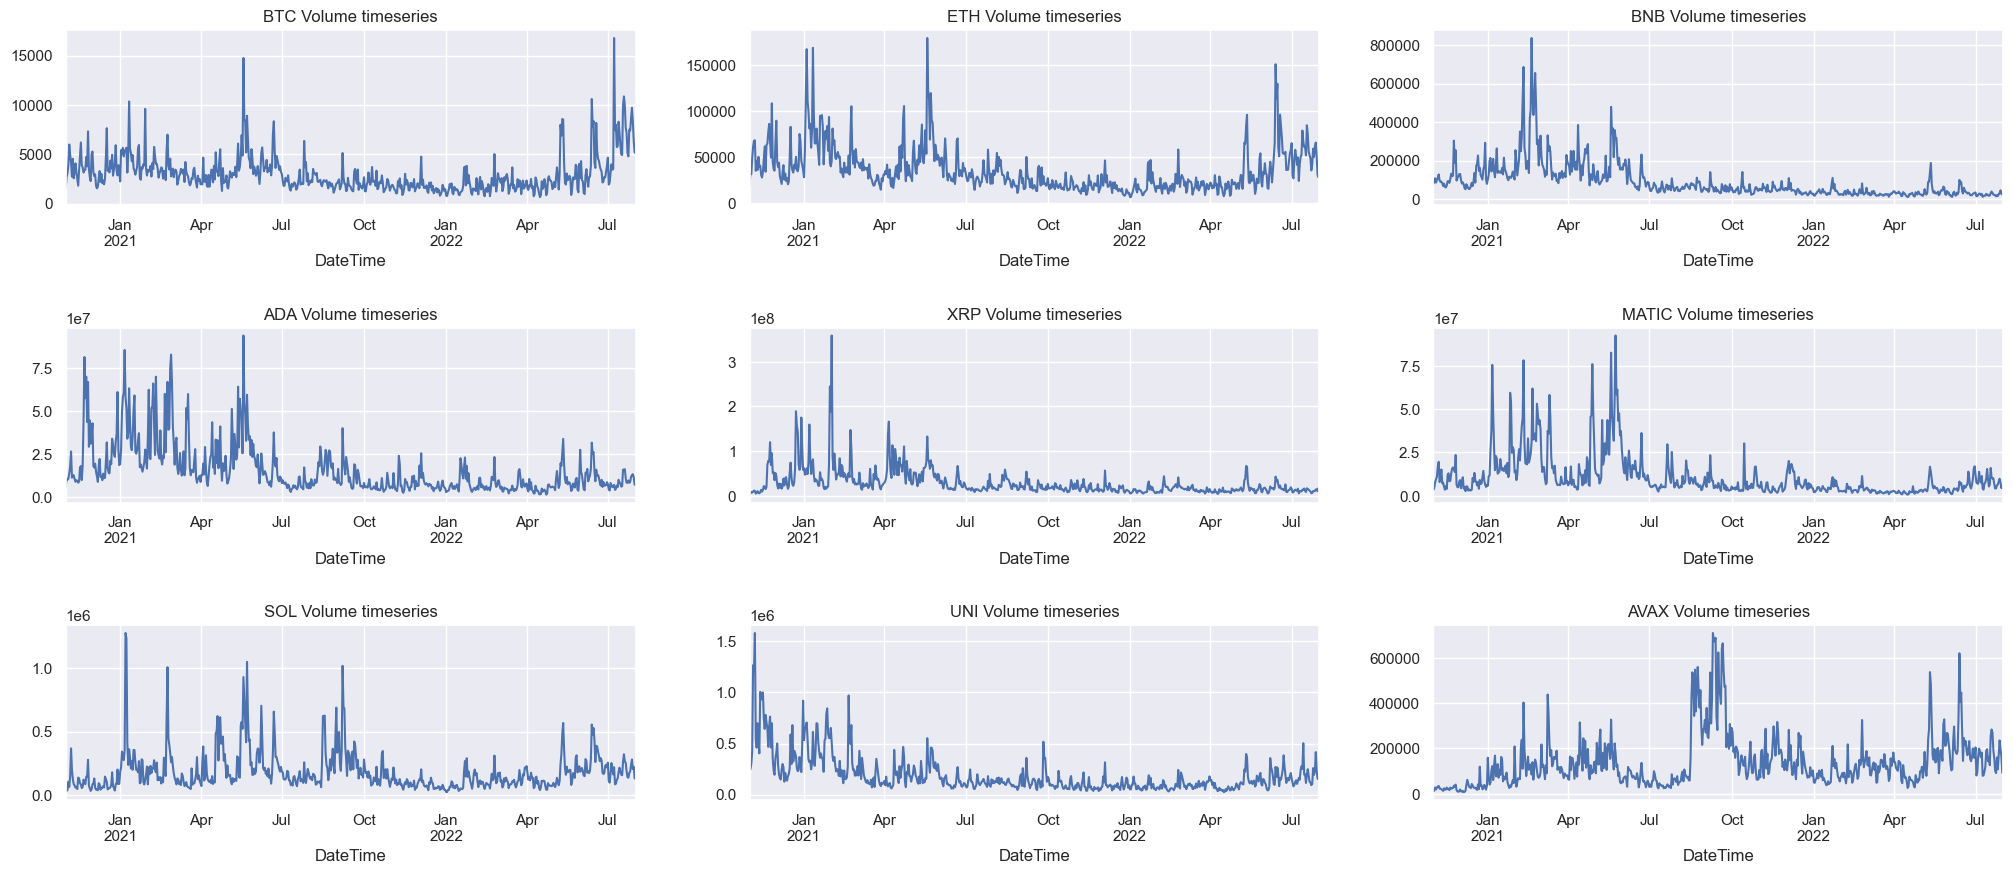

In [116]:
Wrangle.plot_all_series(df_spot, df_perp, '2020-11-01', '2022-08-01', 'Volume', resample_period='D')

### Correlation of Returns for Alt-coins against BTC

Observations:
- Alt coins correlation with BTC exhibit same pattern with one another (alt coins correlation with BTC most likely has high correlation with one another)

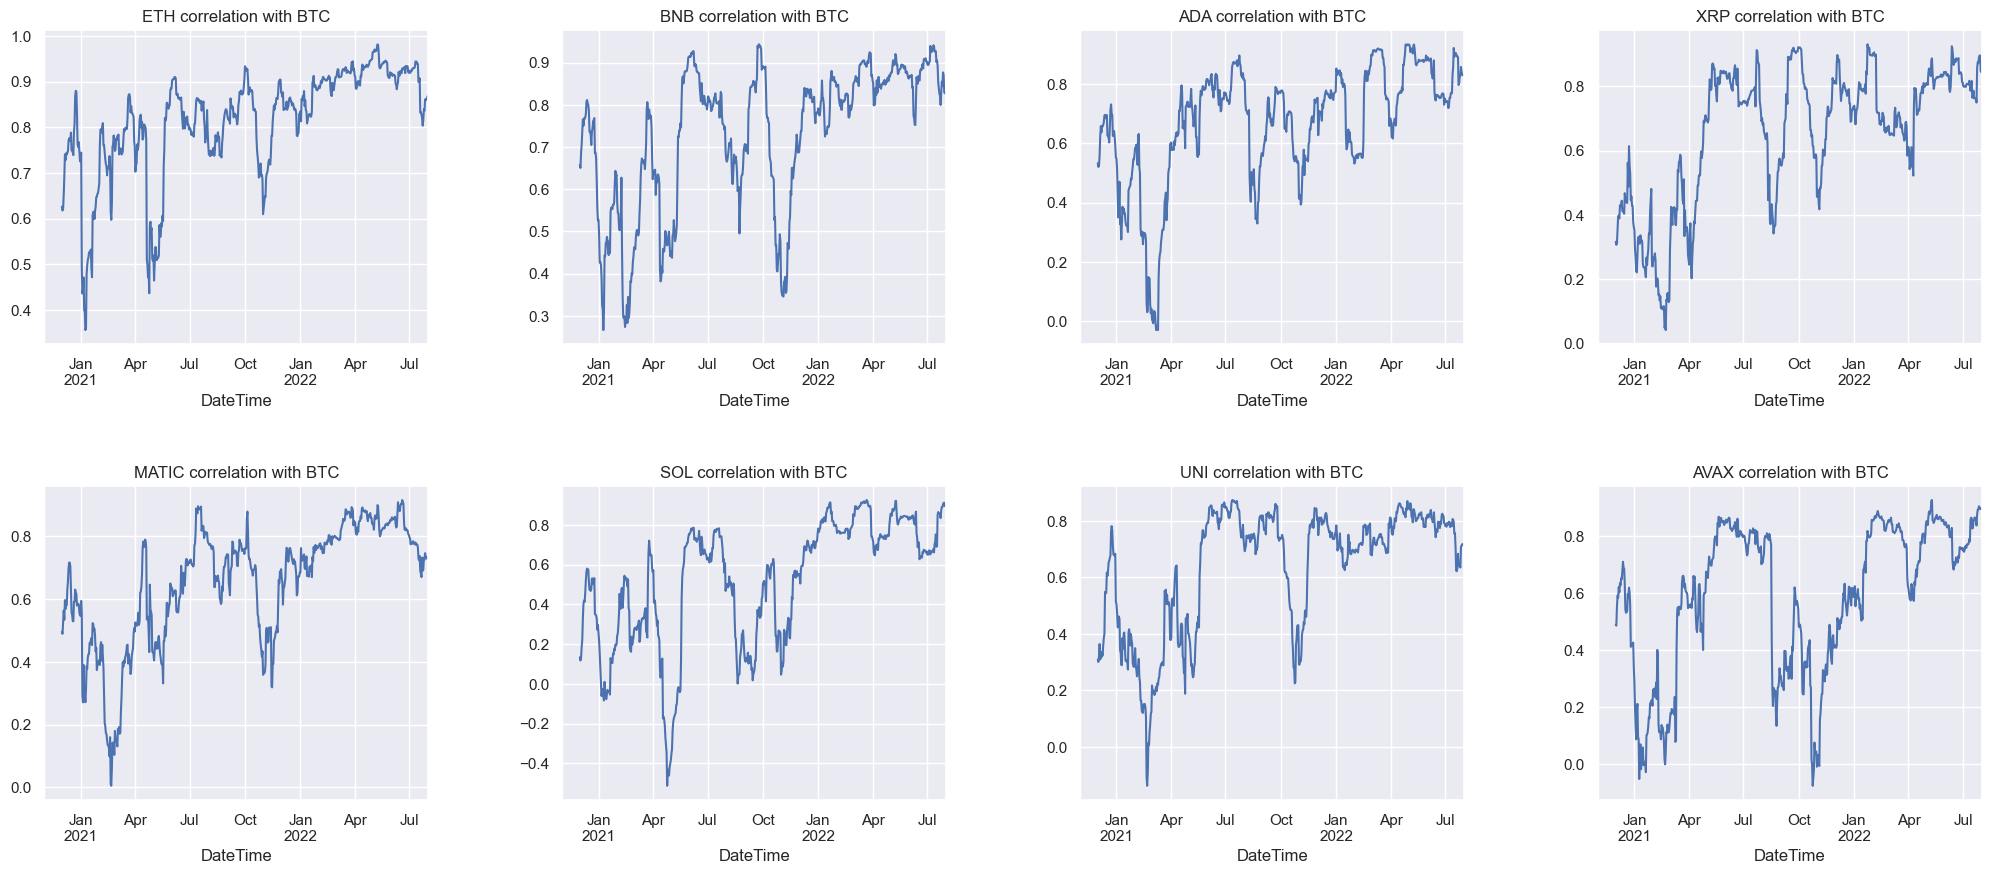

In [118]:
Wrangle.plot_corr_with_BTC(df_spot, df_perp, '2020-11-01', '2022-08-01', 30, 'D')

## BackTrader Cerebro for BTC-USDT
We use BackTrader to build the Naive Strategy from ground up. BackTrader is used due to its visualisation capabilities and an array of indicators. Any ticker used from the .pkl file has to be resampled to 'H'. The base strategy is run on BTC-USDT first using Hurst (calculated with compute_Hc) on the rolling window of either a week or month. 

For hurst; > 0.5 -> mean-reverting, > 0.5 -> trend-following.

Other indicators used: Bollinger bands (one week), Stochastic RSI

After testing the base strategy, we can further optimise using VectorBT in the walk-forward analysis. 

In [99]:
class Backtester:

    def __init__(self, datafeed: pd.DataFrame, strategy):
        self.datafeed = datafeed
        self.strategy = strategy
        self.cerebro = Cerebro()
        self.cerebro.adddata(self.DataFeed(dataname=datafeed))
        self.cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')

    # always initialise the run *** 
    def basic_run(self):
        self.cerebro.addstrategy(self.strategy)
        self.cerebro.run()

    def opt_run(self):
        self.cerebro.optstrategy(self.strategy, bb_period=range(5, 20), rsi_period=range(5, 20))
        self.cerebro.run()

    def get_data(self) -> pd.DataFrame:
        return self.datafeed

    def plot_backtest_results(self):
        %matplotlib inline
        plt.rcParams['figure.figsize'] = [15, 12]
        plt.rcParams.update({'font.size': 12})
        self.cerebro.plot(iplot=False)

    class DataFeed(PandasData):
        lines = ('ret', 'hurst', 'z_score')
        params = (
            ('ret', 'ret'),
            ('hurst', 'hurst'),
            ('z_score', 'z_score')
        )
        datafields = PandasData.datafields + (['ret', 'hurst', 'z_score'])

    # add hurst data
    class HurstExp(Indicator):
        lines = ('hurst',)

        def __init__(self):
            self.lines.hurst = self.data.hurst

    # add zscore data
    class Zscore(Indicator):
        lines = ('z_score', )

        def __init__(self):
            self.lines.z_score = self.data.z_score

    # add ret data
    class Ret(Indicator):
        lines = ('ret',)

        def __init__(self):
            self.lines.ret = self.data.ret

    class StochRSI(Indicator):
        lines = ('stochrsi',)
        params = dict(
            period=672,  # to apply to RSI
            pperiod=None,  # if passed apply to HighestN/LowestN, else "period"
        )

        def __init__(self):
            rsi = bt.ind.RSI(self.data, period=self.p.period)
            pperiod = self.p.pperiod or self.p.period
            maxrsi = bt.ind.Highest(rsi, period=pperiod)
            minrsi = bt.ind.Lowest(rsi, period=pperiod)
            self.l.stochrsi = (rsi - minrsi) / (maxrsi - minrsi)

## Define Strategies
The Naive strategy is done by initialising 3 indicators
1. Bollinger band
2. Stochastic RSI
3. Hurst Exponent (< 0.5 for mean-reverting)

** z-score and ret data are not important for now

We use the output chart and and see if the strategy is working (e.g. buying at the lows and selling at the highs)

In [128]:
# test on the base strategy without any parameters optimised
class NaiveStrategy(bt.Strategy):
    
    params = (
        ('bb_period', 672), ('rsi_period', 672),
    )

    def __init__(self):
        self.bb = BollingerBands(self.data, period=self.params.bb_period)
        # self.macd = bt.indicators.MACD(period_me1=168, period_me2=336, period_signal=120)
        self.rsi = Backtester.StochRSI(self.data, period=self.params.rsi_period)
        self.hurst = Backtester.HurstExp(self.data)
        # self.ret =  Backtester.Ret(self.data)
        self.zscore = Backtester.Zscore(self.data)
    
    # log the dates of the buy and sell order
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')
    
    # no slippage accounted for in this strategy
    def next(self):
        # Series is mean reverting
        if self.hurst[-1] < 0.5 and self.rsi.lines[-1] > 0.3 and self.rsi.lines[-1] < 0.7:
            if self.data.close[-1] > self.bb.lines.bot and self.data.close[-2] < self.bb.lines.bot:
                self.log("Sell order {}".format(self.data.close[0]))
                order = self.buy(price=self.data.close)
            elif self.data.close[-1] < self.bb.lines.top and self.data.close[-2] > self.bb.lines.top:
                self.log("Buy order {}".format(self.data.close[0]))
                order = self.sell(price=self.data.close)
        # for persistence series
        elif self.hurst[-1] > 0.5:
            if self.rsi.lines[-1] > 0.7:
                self.log("Sell order {}".format(self.data.close[0]))
                order = self.sell(price=self.data.close)
            elif self.rsi.lines[-1] < 0.3:
                self.log("Buy order {}".format(self.data.close[0]))
                order = self.buy(price=self.data.close)
            

In [101]:
# test_data used for BackTrader
test_data = Wrangle.get_backtest_ticker_with_hurst_df(
    df_spot, 'BINANCE_SPOT_BTC_USDT', 
    start_dt='2020-11-01', end_dt='2021-11-01',
    rolling_window=int(168), resample_period='H', 
    with_z_score=True                      
)

2021-01-02 Sell order 32178.33
2021-01-03 Sell order 32447.94
2021-01-03 Sell order 32585.09
2021-01-03 Sell order 32741.67
2021-01-03 Sell order 32573.87
2021-01-03 Sell order 33192.53
2021-01-03 Sell order 33758.67
2021-01-03 Sell order 33967.13
2021-01-03 Sell order 34452.34
2021-01-03 Sell order 34367.68
2021-01-03 Sell order 34190.55
2021-01-03 Sell order 33877.96
2021-01-03 Sell order 34413.53
2021-01-03 Sell order 34103.72
2021-01-03 Sell order 33880.0
2021-01-03 Sell order 33811.54
2021-01-03 Sell order 33506.62
2021-01-03 Sell order 32676.74
2021-01-03 Sell order 32909.27
2021-01-03 Sell order 32769.76
2021-01-03 Sell order 32772.21
2021-01-03 Sell order 33726.21
2021-01-03 Sell order 33558.34
2021-01-03 Sell order 33119.14
2021-01-03 Sell order 33000.05
2021-01-04 Sell order 32843.88
2021-01-04 Sell order 33191.04
2021-01-04 Sell order 33454.22
2021-01-04 Sell order 33505.16
2021-01-04 Sell order 33257.55
2021-01-04 Sell order 32813.01
2021-01-04 Sell order 33100.02
2021-01-0

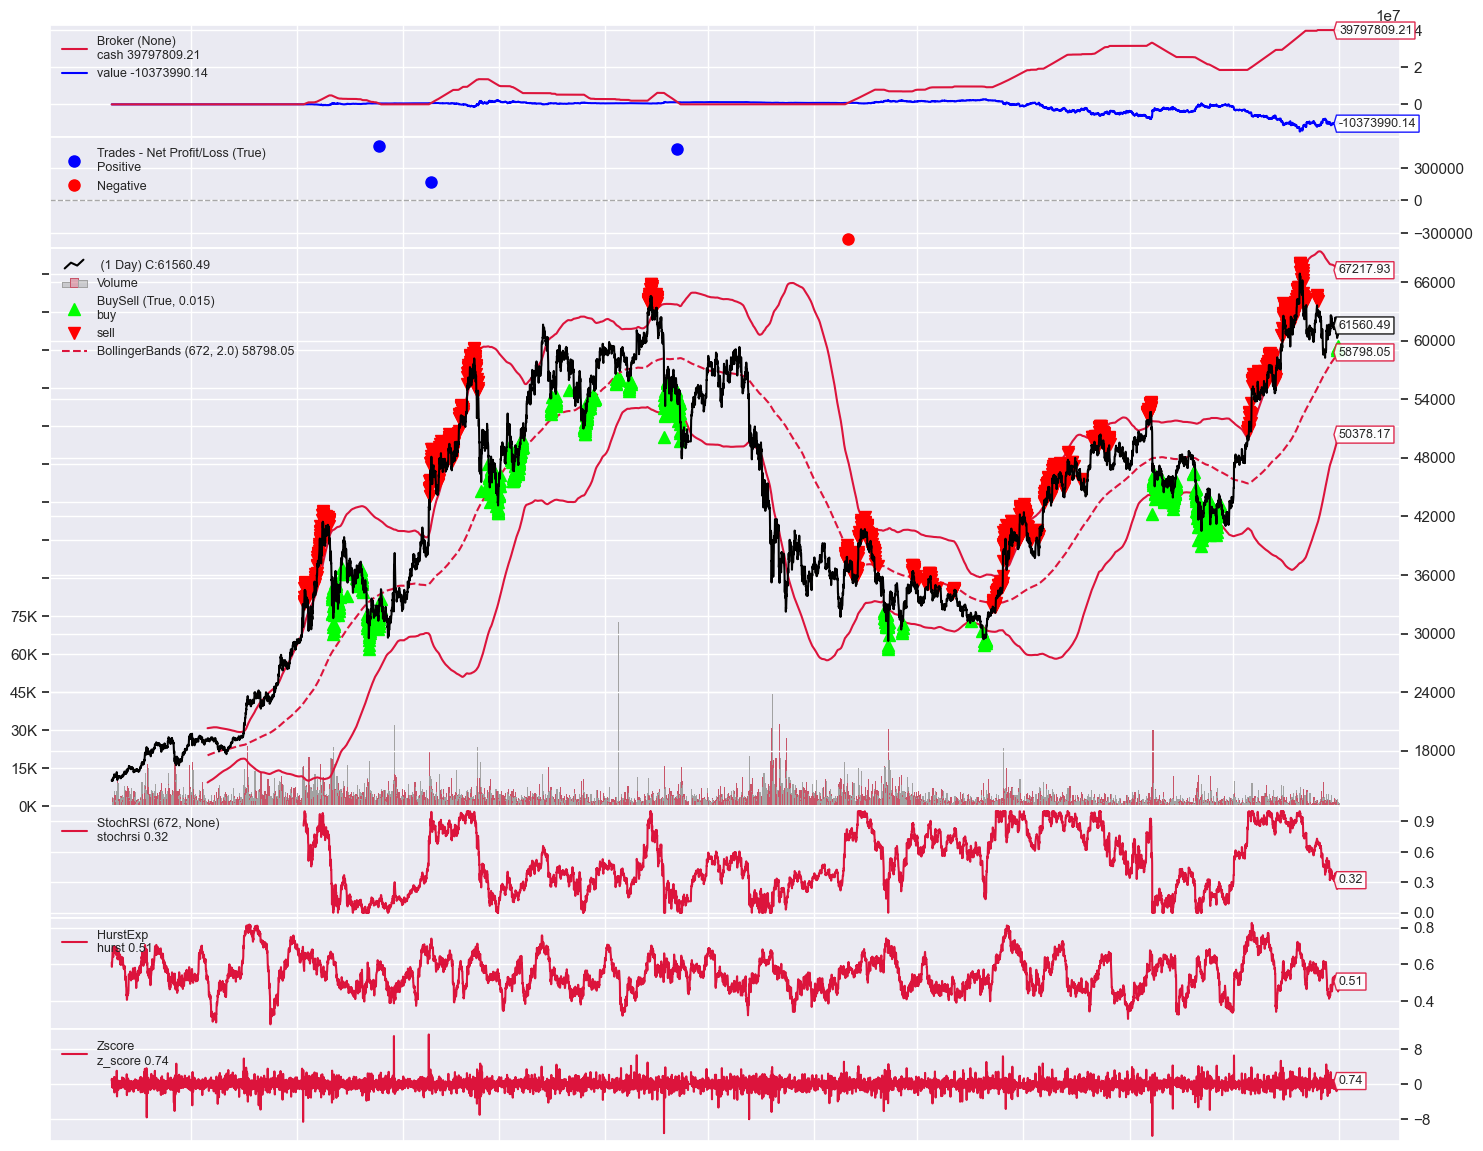

In [129]:
# run the backtester on test data
backtester = Backtester(test_data, NaiveStrategy)
backtester.basic_run()
backtester.plot_backtest_results()

Observations
- Tighter Bollinger bands result in higher trade frequency when price is mean reverting accoriding to hurst exponent
- Naive Strategy: the strat is buying on the way down and selling on the way up
- To do: we need to eliminate these wrong entry and exit points (Use walk-forward analysis)
- *** Important Events: 11-May-2020: Btc halving

## Walk Forward Analysis for BTC

Steps for analysis:
1. Convert trading strategy from Backtrader into a custom indicator in VectorBT
2. Split time series for BTC into n windows of (in-sample, out-of-sample) data
3. For each window, feed in the in-sample data for parameters optimization (Bollinger Bands look back window etc)
4. Obtain the best parameters for each window that produces the best performance (sharpe ratio etc)
5. For each window, feed in the obtained best parameters for out-of-sample data
6. Validate the results

In [40]:
BTC_data = Wrangle.get_backtest_ticker_df(
    df_spot, 'BINANCE_SPOT_BTC_USDT', 
    start_dt='2020-11-01', end_dt='2021-11-01',
    rolling_window=int(168), resample_period='H')

### Define Hurst Exponent Indicator Based on hurst package

The hurst package uses Rescaled Range to produce hurst values

- The objective is to test different windows for the hurst exponent. 
- For example, what windows of the hurst exponent would be the best?
- Testing with one week, two weeks, three weeks, one month

In [28]:
def hurst_exponent_rs_indicator(close: pd.Series, returns: pd.Series, window=Wrangle.one_month):
    return pd.DataFrame(returns).rolling(window).apply(lambda x: compute_Hc(x, kind='change')[0])

hurst_ind = vbt.IndicatorFactory(
    class_name='HurstExponentRSIndicator',
    short_name='hurst_rs_ind',
    # has to be explicitly defined
    input_names=['close', 'returns'],
    # pre-defined
    param_names=['window'],
    output_names=['hurst']
).from_apply_func(hurst_exponent_rs_indicator, window=Wrangle.one_month)

### Define Combined Trading Strategy

The combined trading strategy is a discrete signal that produces values in the set {-1, 0, 1}.\

Signal interpretation:
- -1 : sell signal
- 0: do nothing
- 1: buy signal

In [56]:
# @jit(nopython=True)
def produce_signal(hurst, close, returns, rsi_window, bb_window):
    rsi = vbt.RSI.run(close, window=rsi_window).rsi.to_numpy()
    bb = vbt.BBANDS.run(close, window=bb_window)
    crossed_above_bb_upper = bb.close_crossed_above(bb.upper).to_numpy()
    crossed_below_bb_lower = bb.close_crossed_below(bb.lower).to_numpy()

    # sell signal
    trend = np.where((hurst < 0.5) & (rsi > 40) & (rsi < 60) & (crossed_above_bb_upper == True), -1, 0)
    # buy signal
    trend = np.where((hurst < 0.5) & (rsi > 40) & (rsi < 60) & (crossed_below_bb_lower == True), 1, trend)

    return trend

def signal(close, returns, hurst_window=Wrangle.one_month, rsi_window=Wrangle.one_month, bb_window=Wrangle.one_week):
    # extract the calculated hurst 
    hurst = hurst_ind.run(close, returns, window=hurst_window).hurst.to_numpy()
    return produce_signal(hurst, close, returns, rsi_window, bb_window)

signal = vbt.IndicatorFactory(
    class_name='Signal',
    short_name='signal',
    input_names=['close', 'returns'],
    param_names=['hurst_window', 'rsi_window', 'bb_window'],
    output_names=['signal']
).from_apply_func(signal, hurst_window=Wrangle.one_month, rsi_window=Wrangle.one_month, bb_window=Wrangle.one_week)


In [34]:
sig = signal.run(BTC_data['Close'], BTC_data['ret'])

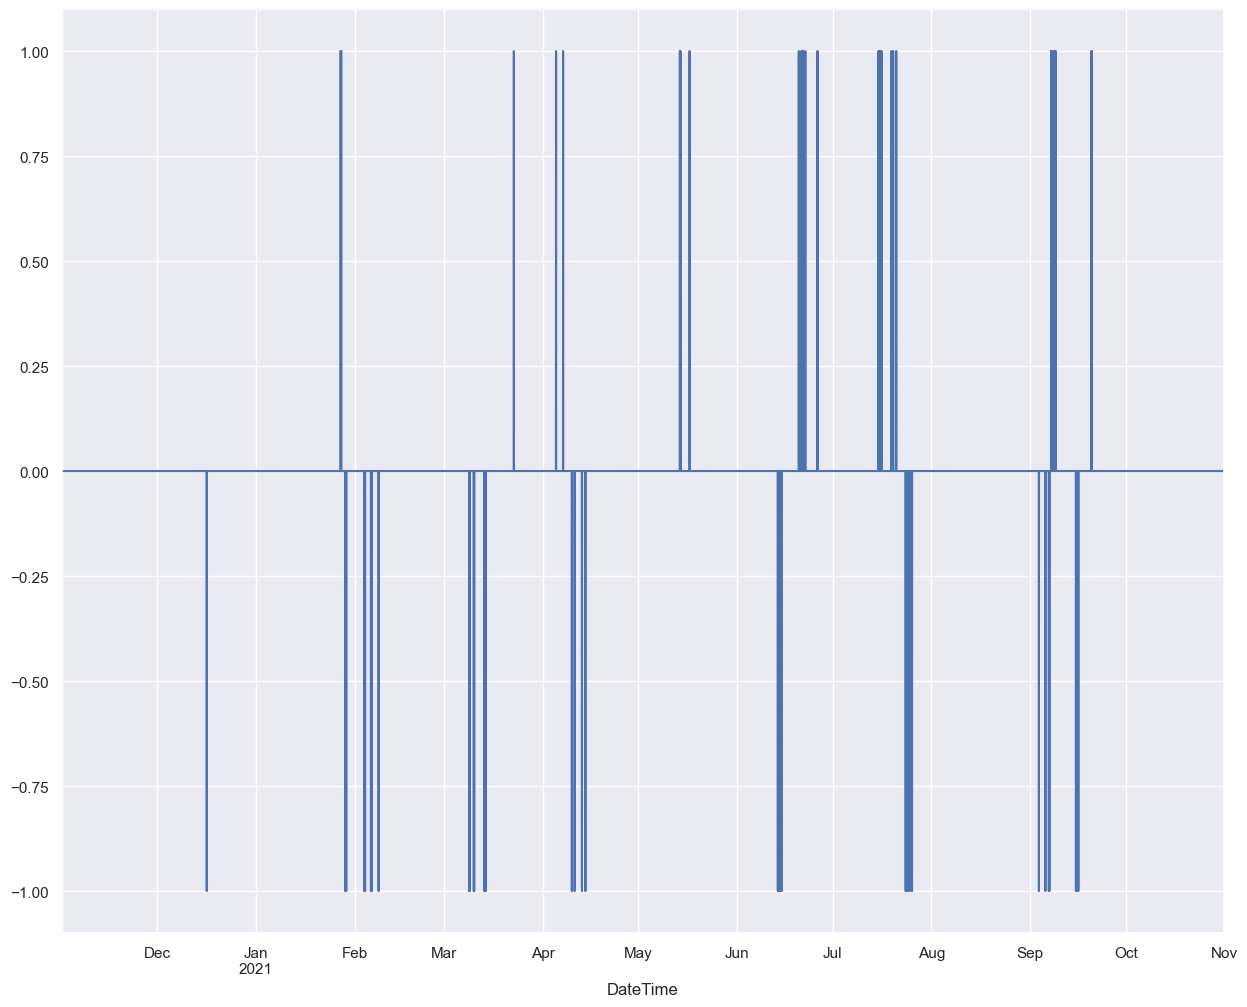

In [35]:
sig.signal.plot()

In [36]:
entries = sig.signal == 1
exits = sig.signal == -1

portfolio = vbt.Portfolio.from_signals(BTC_data['Close'], entries, exits)

### Optimizize Parameters for Combined Indicator

Window values in the [168, 336, 504, 672] will be fed into the backtester for optimization. The combination that returns the highest performace metric will be used for validation phase (using out-of-sample data)

In [37]:
windows = np.arange(Wrangle.one_week, Wrangle.one_month+1, Wrangle.one_week)

# the windows will be overwritten in the base class
sig_comb = signal.run(BTC_data['Close'], BTC_data['ret'], hurst_window=windows, rsi_window=windows, bb_window=windows)

In [86]:
# testing different hurst windows
test_arr = [168, 336, 504, 672]
for period in test_arr:
    sig_comb = signal.run(BTC_data['Close'], BTC_data['ret'], hurst_window=period)
    entries = sig_comb.signal_equal(1)
    exits = sig_comb.signal_equal(-1)
    portfolio2 = vbt.Portfolio.from_signals(BTC_data['Close'], entries, exits)
    print(f'Sharpe Ratio for Hurst in {period} period \n {portfolio2.sharpe_ratio()}')

Sharpe Ratio for Hurst in 168 period 
 1.2995167212986363
Sharpe Ratio for Hurst in 336 period 
 2.3466772175189194
Sharpe Ratio for Hurst in 504 period 
 1.26925113769198
Sharpe Ratio for Hurst in 672 period 
 0.9415883482792321


In [38]:
entries = sig_comb.signal_equal(1)
exits = sig_comb.signal_equal(-1)

portfolio2 = vbt.Portfolio.from_signals(BTC_data['Close'], entries, exits)

In [61]:
# show the sharpe_ratios
portfolio2.sharpe_ratio()

signal_hurst_window  signal_rsi_window  signal_bb_window
168                  168                168                 1.409744
336                  336                336                 1.217638
504                  504                504                 1.004506
672                  672                672                 0.631560
Name: sharpe_ratio, dtype: float64

In [47]:
BTC_data['Close'].vbt.rolling_split(n=10, window_len=1500, set_lens=(300,), left_to_right=False, plot=True)

AttributeError: type object 'DOMWidget' has no attribute '_ipython_display_'

FigureWidget({
    'data': [{'colorscale': [[0.0, '#1f77b4'], [1.0, '#1f77b4']],
              'hoverongaps': False,
              'name': '0',
              'showlegend': True,
              'showscale': False,
              'type': 'heatmap',
              'uid': '23c36e81-898d-4f75-8872-65d8d9cc564c',
              'x': array([datetime.datetime(2020, 11, 1, 1, 0, tzinfo=<UTC>),
                          datetime.datetime(2020, 11, 1, 2, 0, tzinfo=<UTC>),
                          datetime.datetime(2020, 11, 1, 3, 0, tzinfo=<UTC>), ...,
                          datetime.datetime(2021, 10, 31, 22, 0, tzinfo=<UTC>),
                          datetime.datetime(2021, 10, 31, 23, 0, tzinfo=<UTC>),
                          datetime.datetime(2021, 11, 1, 0, 0, tzinfo=<UTC>)], dtype=object),
              'y': array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=int64),
              'z': array([[nan, nan, nan, ..., nan, nan, nan],
                          [nan, nan, nan, ..., nan, nan, nan],
                          [nan, nan, nan, ..., nan, nan, nan],
                          ...,
                          [nan, nan, nan, ..., nan, nan, nan],
                          [nan, nan, nan, ..., nan, nan, nan],
                          [ 0.,  0.,  0., ..., nan, nan, nan]])},
             {'colorscale': [[0.0, '#ff7f0e'], [1.0, '#ff7f0e']],
              'hoverongaps': False,
              'name': '1',
              'showlegend': True,
              'showscale': False,
              'type': 'heatmap',
              'uid': 'a18659d0-7c5d-4fd0-8505-b91b867e2489',
              'x': array([datetime.datetime(2020, 11, 1, 1, 0, tzinfo=<UTC>),
                          datetime.datetime(2020, 11, 1, 2, 0, tzinfo=<UTC>),
                          datetime.datetime(2020, 11, 1, 3, 0, tzinfo=<UTC>), ...,
                          datetime.datetime(2021, 10, 31, 22, 0, tzinfo=<UTC>),
                          datetime.datetime(2021, 10, 31, 23, 0, tzinfo=<UTC>),
                          datetime.datetime(2021, 11, 1, 0, 0, tzinfo=<UTC>)], dtype=object),
              'y': array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=int64),
              'z': array([[nan, nan, nan, ...,  1.,  1.,  1.],
                          [nan, nan, nan, ..., nan, nan, nan],
                          [nan, nan, nan, ..., nan, nan, nan],
                          ...,
                          [nan, nan, nan, ..., nan, nan, nan],
                          [nan, nan, nan, ..., nan, nan, nan],
                          [nan, nan, nan, ..., nan, nan, nan]])}],
    'layout': {'height': 211,
               'legend': {'orientation': 'h',
                          'traceorder': 'normal',
                          'x': 1,
                          'xanchor': 'right',
                          'y': 1.02,
                          'yanchor': 'bottom'},
               'margin': {'b': 30, 'l': 30, 'r': 30, 't': 30},
               'template': '...',
               'width': 700,
               'yaxis': {'type': 'category'}}
})

Split close prices and returns into n windows of (in-sample, out-of-sample) data

In [63]:
(in_sample_prices, in_sample_prices_dates), (out_sample_prices, out_sample_prices_dates) = BTC_data['Close'].vbt.rolling_split(n=10, window_len=1500, set_lens=(300,), left_to_right=False)
(in_sample_rets, in_sample_rets_dates), (out_sample_rets, out_sample_rets_dates) = BTC_data['ret'].vbt.rolling_split(n=10, window_len=1500, set_lens=(300,), left_to_right=False)

Feed in-sample prices into backtester

In [69]:
sig_comb2 = signal.run(in_sample_prices, in_sample_rets, hurst_window=windows, rsi_window=windows, bb_window=windows)

Obtain best performing parameters for each window

In [77]:
entries = sig_comb2.signal_equal(1)
exits = sig_comb2.signal_equal(-1)

portfolio3 = vbt.Portfolio.from_signals(in_sample_prices, entries, exits, freq='H')

In [84]:
performance = portfolio3.sharpe_ratio()

In [85]:
performance[performance.groupby('split_idx').idxmax()].index

MultiIndex([(336, 336, 336, 0),
            (168, 168, 168, 1),
            (504, 504, 504, 2),
            (504, 504, 504, 3),
            (336, 336, 336, 4),
            (672, 672, 672, 5),
            (504, 504, 504, 6),
            (672, 672, 672, 7),
            (168, 168, 168, 8),
            (504, 504, 504, 9)],
           names=['signal_hurst_window', 'signal_rsi_window', 'signal_bb_window', 'split_idx'])

test combs

In [94]:
sig_comb4 = signal.run_combs(in_sample_prices, in_sample_rets, hurst_window=windows, rsi_window=windows, bb_window=windows)